# <span style="color:red"> ***** </span><span style="color:blue"> Project Data File Folder</span> <span style="color:green"> ***** </span>

In [1]:
import sys, os
parent_dir = os.path.dirname(os.path.realpath('/Users/akpy27/Downloads/Untitled'))
# To get one directory up from the current file
project_dir = os.path.abspath(os.path.join(parent_dir, "./Untitled/"))

sys.path.insert(0,project_dir)

print ('Parent Directory Path:', parent_dir)
print ('Project Path:', project_dir)

Parent Directory Path: /Users/akpy27/Downloads
Project Path: /Users/akpy27/Downloads/Untitled


# <span style="color:red"> ***** </span><span style="color:blue"> OpenSmile ComParE_2016 </span> <span style="color:green"> ***** </span>


# <span style="color:red"> ***** </span><span style="color:blue"> Feature Extraction</span> <span style="color:green"> ***** </span>

In [2]:
import librosa
import torchaudio
import numpy as np
from glob import glob
from tqdm import tqdm

In [3]:
import opensmile
smile = opensmile.Smile(
      feature_set=opensmile.FeatureSet.ComParE_2016,
      feature_level=opensmile.FeatureLevel.Functionals,
  )

len(smile.feature_names)

6373

In [4]:

def extract_feature(audio_file, noise=False):

  audio,sample_fs = torchaudio.load(audio_file)

  sample_audio = audio.numpy().reshape(-1)

  smile = opensmile.Smile(
      feature_set=opensmile.FeatureSet.ComParE_2016,
      feature_level=opensmile.FeatureLevel.Functionals,
  )
  
  if noise:
    y_preemphasized = librosa.effects.preemphasis(y=sample_audio)
    y = smile.process_signal(y_preemphasized, sample_fs)
  else:
    y = smile.process_signal(sample_audio, sample_fs)

  return np.array(y.iloc[0])




In [5]:
def get_label(file_name):
  '''
  Function to retrieve output labels from filenames
  '''
  if 'ROC' in file_name:
    label=0
  elif 'LES' in file_name:
    label=1
  elif 'DCB' in file_name:
    label=2
  elif 'PRV' in file_name:
    label=3
  elif 'VLD' in file_name:
    label=4
  elif 'DTA' in file_name:
    label=5
  else:
    raise ValueError('invalid file name')
  return label

# <span style="color:red"> ***** </span><span style="color:blue"> Train and Test Data Preparation</span> <span style="color:green"> ***** </span>

In [6]:

#First we obtain the list of all files in the train directory
train_files = glob(project_dir + "/project_data/train/*.wav")

#Let's sort it so that we're all using the same file list order
#and you can continue processing the features from a given file if it stops
#partway through running
train_files.sort()

train_feat_smile=[]
train_label=[]

for wav in tqdm(train_files):

  train_feat_smile.append(extract_feature(wav))
  train_label.append(get_label(wav))

100%|██████████| 8980/8980 [19:05<00:00,  7.84it/s]


In [7]:
#Now we obtain the list of all files in the test_clean directory
test_clean_files = glob(project_dir + '/project_data/test_clean/*.wav')

#Similar to above, we sort the files
test_clean_files.sort()

test_clean_feat_smile=[]
test_clean_label=[]

for wav in tqdm(test_clean_files):

  test_clean_feat_smile.append(extract_feature(wav))
  test_clean_label.append(get_label(wav))

100%|██████████| 2533/2533 [05:27<00:00,  7.73it/s]


In [8]:
#Finally we obtain the list of all files in the test_noisy directory
test_noisy_files = glob(project_dir + '/project_data/test_noisy/*.wav')

#Similar to above, we sort the files
test_noisy_files.sort()

test_noisy_feat_smile=[]
test_noisy_label=[]

for wav in tqdm(test_noisy_files):

  test_noisy_feat_smile.append(extract_feature(wav))
  test_noisy_label.append(get_label(wav))

100%|██████████| 3238/3238 [07:31<00:00,  7.18it/s]


In [9]:
import re

feat_names_smile  = list(smile.feature_names)

def remove_non_alphanumeric(feat_names_smile):
    """
    Remove all non-alphanumeric characters from entries in feat_names_smile.

    Args:
        feat_names_os (list of str): List of feature names.

    Returns:
        list of str: List of cleaned feature names.
    """
    cleaned_feat_names = [re.sub(r'\W+', '', name) for name in feat_names_smile]
    return cleaned_feat_names

feat_names_smile = remove_non_alphanumeric(feat_names_smile)


# <span style="color:red"> ***** </span><span style="color:blue"> Model Training and Predictions</span> <span style="color:green"> ***** </span>

In [10]:
import xgboost
import numpy as np
import shap
import pandas as pd


train_feat_smile_df = pd.DataFrame(data=np.stack(train_feat_smile), columns=feat_names_smile)
y_train=np.stack(train_label)

test_clean_feat_smile_df = pd.DataFrame(data=np.stack(test_clean_feat_smile), columns=feat_names_smile)
y_test_clean=np.stack(test_clean_label)

test_noisy_feat_smile_df = pd.DataFrame(data=np.stack(test_noisy_feat_smile), columns=feat_names_smile)
y_test_noisy=np.stack(test_noisy_label)

model_smile = xgboost.XGBClassifier()
model_smile.fit(train_feat_smile_df,y_train)

print("Train Clean Opensmile Acc =", np.sum(y_train==model_smile.predict(train_feat_smile_df))/len(y_train))

print("Test Clean Opensmile Acc =", np.sum(y_test_clean==model_smile.predict(test_clean_feat_smile_df))/len(y_test_clean))

print("Test Noisy Opensmile Acc =", np.sum(y_test_noisy==model_smile.predict(test_noisy_feat_smile_df))/len(y_test_noisy))


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Train Clean Opensmile Acc = 1.0
Test Clean Opensmile Acc = 0.6154757204895381
Test Noisy Opensmile Acc = 0.5880172946263126


# <span style="color:red"> ***** </span><span style="color:blue"> Interpreting Results and Explainability</span> <span style="color:green"> ***** </span>

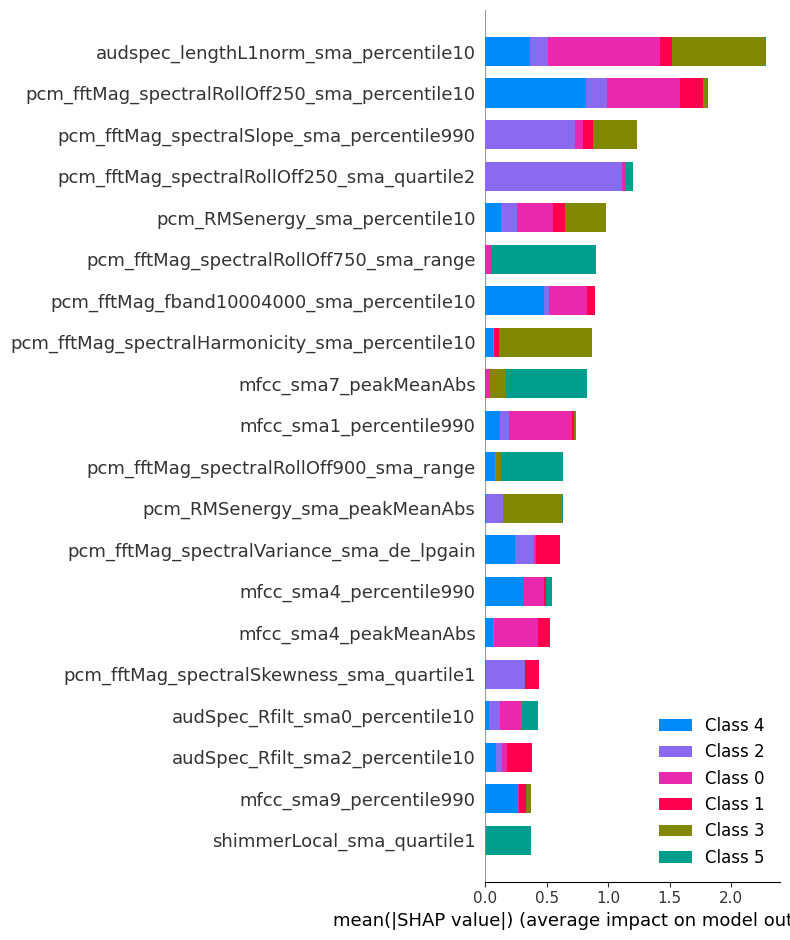

In [11]:
import shap

# Explain the model's predictions using SHAP by computing SHAP values
explainer = shap.Explainer(model_smile)
shap_values = explainer.shap_values(train_feat_smile_df)

#Convert the shap values for each class to a single list
shap_as_list=[]
for i in range(6):
    shap_as_list.append(shap_values[:,:,i])

# Plot the SHAP values
shap.summary_plot(shap_as_list, train_feat_smile_df, plot_type="bar")

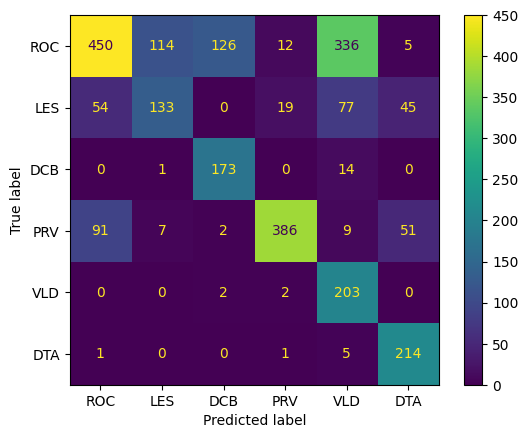

In [12]:
from sklearn import metrics
import matplotlib.pyplot as plt

confusion_matrix_clean = metrics.confusion_matrix(y_test_clean, model_smile.predict(test_clean_feat_smile_df))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_clean, display_labels = ['ROC','LES','DCB','PRV','VLD', 'DTA'])
cm_display.plot()
plt.show()

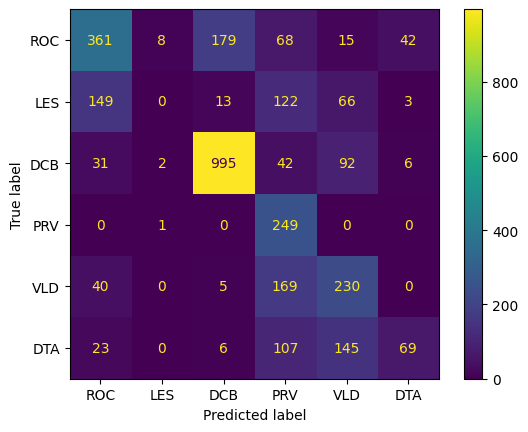

In [13]:
confusion_matrix_noisy = metrics.confusion_matrix(y_test_noisy, model_smile.predict(test_noisy_feat_smile_df))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_noisy, display_labels = ['ROC','LES','DCB','PRV','VLD', 'DTA'])
cm_display.plot()
plt.show()

# <span style="color:red"> ***** </span><span style="color:blue"> OpenSmile eGeMAPSv02</span> <span style="color:green"> ***** </span>

# <span style="color:red"> ***** </span><span style="color:blue"> Feature Extraction eGeMAPSv02</span> <span style="color:green"> ***** </span>

In [14]:
smile1 = opensmile.Smile(
    feature_set=opensmile.FeatureSet.eGeMAPSv02,
    feature_level=opensmile.FeatureLevel.LowLevelDescriptors,
)
len(smile1.feature_names)

25

In [15]:

import torchaudio
import numpy as np

def extract_feature1(wav):

  audio,sample_fs = torchaudio.load(wav)

  sample_audio = audio.numpy().reshape(-1)

  smile1=opensmile.Smile(
      feature_set=opensmile.FeatureSet.eGeMAPSv02,
      feature_level=opensmile.FeatureLevel.LowLevelDescriptors,
  )

  y1 = smile1.process_signal(
      sample_audio,
      sample_fs
  )

  return np.array(y1.iloc[0])

In [16]:
def get_label(file_name):
  '''
  Function to retrieve output labels from filenames
  '''
  if 'ROC' in file_name:
    label=0
  elif 'LES' in file_name:
    label=1
  elif 'DCB' in file_name:
    label=2
  elif 'PRV' in file_name:
    label=3
  elif 'VLD' in file_name:
    label=4
  elif 'DTA' in file_name:
    label=5
  else:
    raise ValueError('invalid file name')
  return label

# <span style="color:red"> ***** </span><span style="color:blue"> Train and Test Data Preparation</span> <span style="color:green"> ***** </span>

In [17]:
#First we obtain the list of all files in the train directory
train_files = glob(project_dir + "/project_data/train/*.wav")

#Let's sort it so that we're all using the same file list order
#and you can continue processing the features from a given file if it stops
#partway through running
train_files.sort()

train_feat_smile1=[]
train_label=[]

for wav in tqdm(train_files):

  train_feat_smile1.append(extract_feature1(wav))
  train_label.append(get_label(wav))

100%|██████████| 8980/8980 [16:03<00:00,  9.32it/s]


In [18]:
#Now we obtain the list of all files in the test_clean directory
test_clean_files = glob(project_dir + '/project_data/test_clean/*.wav')

#Similar to above, we sort the files
test_clean_files.sort()

test_clean_feat_smile1=[]
test_clean_label=[]

for wav in tqdm(test_clean_files):

  test_clean_feat_smile1.append(extract_feature1(wav))
  test_clean_label.append(get_label(wav))

100%|██████████| 2533/2533 [04:07<00:00, 10.24it/s]


In [19]:
#Finally we obtain the list of all files in the test_noisy directory
test_noisy_files = glob(project_dir + '/project_data/test_noisy/*.wav')

#Similar to above, we sort the files
test_noisy_files.sort()

test_noisy_feat_smile1=[]
test_noisy_label=[]

for wav in tqdm(test_noisy_files):

  test_noisy_feat_smile1.append(extract_feature1(wav))
  test_noisy_label.append(get_label(wav))

100%|██████████| 3238/3238 [05:06<00:00, 10.57it/s]


In [20]:
import re

feat_names_smile1  = list(smile1.feature_names)

def remove_non_alphanumeric(feat_names_smile1):
    """
    Remove all non-alphanumeric characters from entries in feat_names_smile1.

    Args:
        feat_names_os (list of str): List of feature names.

    Returns:
        list of str: List of cleaned feature names.
    """
    cleaned_feat_names1 = [re.sub(r'\W+', '', name) for name in feat_names_smile1]
    return cleaned_feat_names1

feat_names_smile1 = remove_non_alphanumeric(feat_names_smile1)


# <span style="color:red"> ***** </span><span style="color:blue"> Model Training and Predictions</span> <span style="color:green"> ***** </span>

In [21]:
import xgboost
import numpy as np
import shap
import pandas as pd



train_feat_smile1_df = pd.DataFrame(data=np.stack(train_feat_smile1), columns=feat_names_smile1)
y_train=np.stack(train_label)

test_clean_feat_smile1_df = pd.DataFrame(data=np.stack(test_clean_feat_smile1), columns=feat_names_smile1)
y_test_clean=np.stack(test_clean_label)

test_noisy_feat_smile1_df = pd.DataFrame(data=np.stack(test_noisy_feat_smile1), columns=feat_names_smile1)
y_test_noisy=np.stack(test_noisy_label)

model_smile1 = xgboost.XGBClassifier()
model_smile1.fit(train_feat_smile1_df,y_train)

print("Train Clean Opensmile Acc =", np.sum(y_train==model_smile1.predict(train_feat_smile1_df))/len(y_train))

print("Test Clean Opensmile Acc =", np.sum(y_test_clean==model_smile1.predict(test_clean_feat_smile1_df))/len(y_test_clean))

print("Test Noisy Opensmile Acc =", np.sum(y_test_noisy==model_smile1.predict(test_noisy_feat_smile1_df))/len(y_test_noisy))


Train Clean Opensmile Acc = 0.994097995545657
Test Clean Opensmile Acc = 0.2799052506908804
Test Noisy Opensmile Acc = 0.3143915997529339


# <span style="color:red"> ***** </span><span style="color:blue"> Interpreting Results and Explainability (smile1) </span> <span style="color:green"> ***** </span>

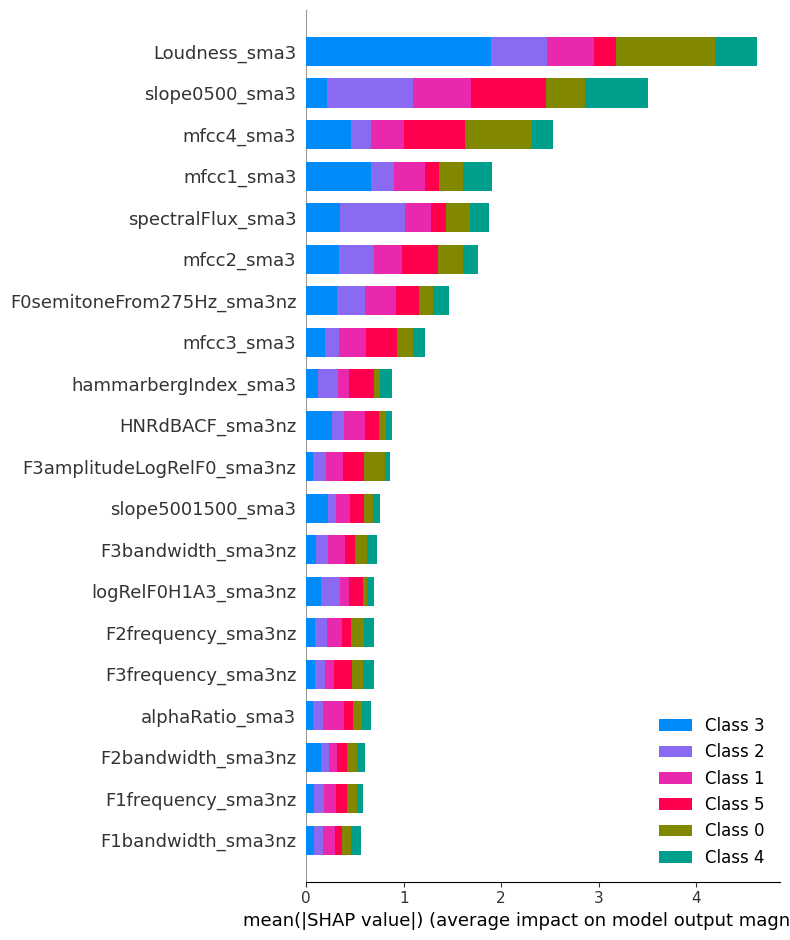

In [22]:
import shap

# Explain the model's predictions using SHAP by computing SHAP values
explainer = shap.Explainer(model_smile1)
shap_values = explainer.shap_values(train_feat_smile1_df)

#Convert the shap values for each class to a single list
shap_as_list=[]
for i in range(6):
    shap_as_list.append(shap_values[:,:,i])

# Plot the SHAP values
shap.summary_plot(shap_as_list, train_feat_smile1_df, plot_type="bar")


# <span style="color:red"> ***** </span><span style="color:blue"> OpenSmile GeMAPSv01b</span> <span style="color:green"> ***** </span>

# <span style="color:red"> ***** </span><span style="color:blue"> Feature Extraction GeMAPSv01b</span> <span style="color:green"> ***** </span>

In [23]:
smile2 = opensmile.Smile(
    feature_set=opensmile.FeatureSet.GeMAPSv01b,
    feature_level=opensmile.FeatureLevel.LowLevelDescriptors,
)
len(smile2.feature_names)

18

In [24]:

import torchaudio
import numpy as np

def extract_feature2(wav):

  audio,sample_fs = torchaudio.load(wav)

  sample_audio = audio.numpy().reshape(-1)

  smile2 = opensmile.Smile(
      feature_set=opensmile.FeatureSet.GeMAPSv01b,
      feature_level=opensmile.FeatureLevel.LowLevelDescriptors,
  )

  y2 = smile2.process_signal(
      sample_audio,
      sample_fs
  )
  return np.array(y2.iloc[0])




In [25]:
def get_label(file_name):
  '''
  Function to retrieve output labels from filenames
  '''
  if 'ROC' in file_name:
    label=0
  elif 'LES' in file_name:
    label=1
  elif 'DCB' in file_name:
    label=2
  elif 'PRV' in file_name:
    label=3
  elif 'VLD' in file_name:
    label=4
  elif 'DTA' in file_name:
    label=5
  else:
    raise ValueError('invalid file name')
  return label

# <span style="color:red"> ***** </span><span style="color:blue"> Train and Test Data Preparation</span> <span style="color:green"> ***** </span>

In [26]:
#First we obtain the list of all files in the train directory
train_files = glob(project_dir + "/project_data/train/*.wav")

#Let's sort it so that we're all using the same file list order
#and you can continue processing the features from a given file if it stops
#partway through running
train_files.sort()

train_feat_smile2=[]
train_label=[]

for wav in tqdm(train_files):

  train_feat_smile2.append(extract_feature2(wav))
  train_label.append(get_label(wav))

100%|██████████| 8980/8980 [12:27<00:00, 12.01it/s]


In [27]:
#Now we obtain the list of all files in the test_clean directory
test_clean_files = glob(project_dir + '/project_data/test_clean/*.wav')

#Similar to above, we sort the files
test_clean_files.sort()

test_clean_feat_smile2=[]
test_clean_label=[]

for wav in tqdm(test_clean_files):

  test_clean_feat_smile2.append(extract_feature2(wav))
  test_clean_label.append(get_label(wav))

100%|██████████| 2533/2533 [03:33<00:00, 11.86it/s]


In [28]:
#Finally we obtain the list of all files in the test_noisy directory
test_noisy_files = glob(project_dir + '/project_data/test_noisy/*.wav')

#Similar to above, we sort the files
test_noisy_files.sort()

test_noisy_feat_smile2=[]
test_noisy_label=[]

for wav in tqdm(test_noisy_files):

  test_noisy_feat_smile2.append(extract_feature2(wav))
  test_noisy_label.append(get_label(wav))

100%|██████████| 3238/3238 [04:37<00:00, 11.65it/s]


In [29]:
import re

feat_names_smile2  = list(smile2.feature_names)

def remove_non_alphanumeric(feat_names_smile2):
    """
    Remove all non-alphanumeric characters from entries in feat_names_smile1.

    Args:
        feat_names_os (list of str): List of feature names.

    Returns:
        list of str: List of cleaned feature names.
    """
    cleaned_feat_names2 = [re.sub(r'\W+', '', name) for name in feat_names_smile2]
    return cleaned_feat_names2

feat_names_smile2 = remove_non_alphanumeric(feat_names_smile2)

# <span style="color:red"> ***** </span><span style="color:blue"> Model Training and Predictions</span> <span style="color:green"> ***** </span>

In [30]:
import xgboost
import numpy as np
import shap
import pandas as pd


train_feat_smile2_df = pd.DataFrame(data=np.stack(train_feat_smile2), columns=feat_names_smile2)
y_train=np.stack(train_label)

test_clean_feat_smile2_df = pd.DataFrame(data=np.stack(test_clean_feat_smile2), columns=feat_names_smile2)
y_test_clean=np.stack(test_clean_label)

test_noisy_feat_smile2_df = pd.DataFrame(data=np.stack(test_noisy_feat_smile2), columns=feat_names_smile2)
y_test_noisy=np.stack(test_noisy_label)

model_smile2 = xgboost.XGBClassifier()
model_smile2.fit(train_feat_smile2_df,y_train)

print("Train Clean Opensmile Acc =", np.sum(y_train==model_smile2.predict(train_feat_smile2_df))/len(y_train))

print("Test Clean Opensmile Acc =", np.sum(y_test_clean==model_smile2.predict(test_clean_feat_smile2_df))/len(y_test_clean))

print("Test Noisy Opensmile Acc =", np.sum(y_test_noisy==model_smile2.predict(test_noisy_feat_smile2_df))/len(y_test_noisy))


Train Clean Opensmile Acc = 0.9736080178173719
Test Clean Opensmile Acc = 0.28661666008685355
Test Noisy Opensmile Acc = 0.2461395923409512


# <span style="color:red"> ***** </span><span style="color:blue"> Interpreting Results and Explainability (smile2) </span> <span style="color:green"> ***** </span>

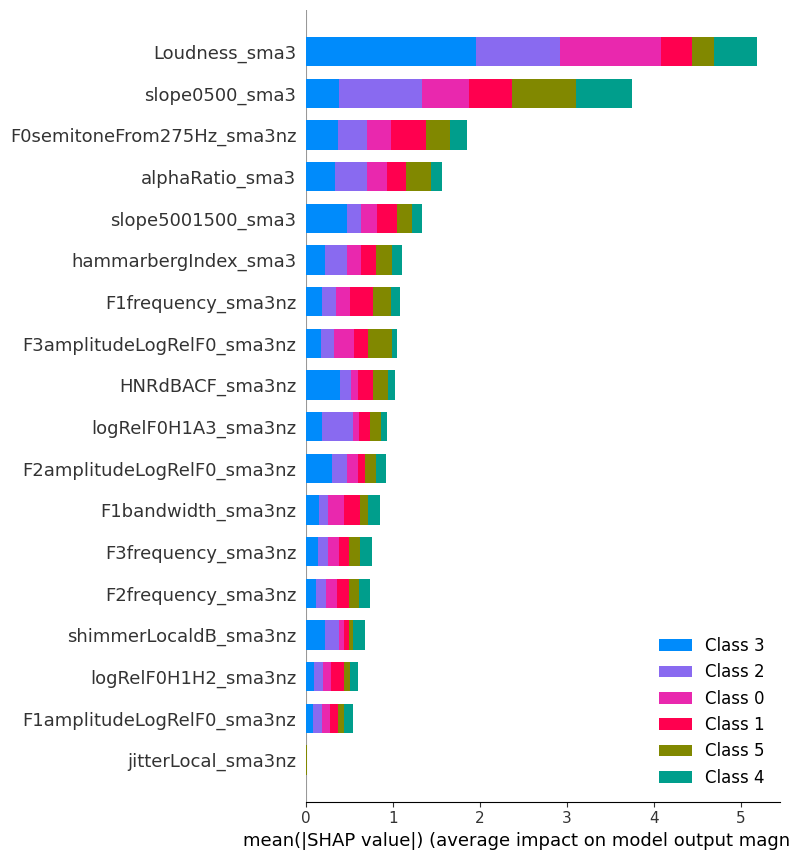

In [31]:
import shap

# Explain the model's predictions using SHAP by computing SHAP values
explainer = shap.Explainer(model_smile2)
shap_values = explainer.shap_values(train_feat_smile2_df)

#Convert the shap values for each class to a single list
shap_as_list=[]
for i in range(6):
    shap_as_list.append(shap_values[:,:,i])

# Plot the SHAP values
shap.summary_plot(shap_as_list, train_feat_smile2_df, plot_type="bar")

# <span style="color:red"> ***** </span><span style="color:blue"> Combined OpenSmile Features  </span> <span style="color:green"> ***** </span>

# <span style="color:red"> ***** </span><span style="color:blue"> Train and Test Data Preparation</span> <span style="color:green"> ***** </span>

# <span style="color:red"> ***** </span><span style="color:blue"> Model Training and Predictions</span> <span style="color:green"> ***** </span>

In [32]:
import xgboost
import numpy as np
import shap
import pandas as pd



train_feat_smile_comb_df = combined_df = pd.concat([train_feat_smile_df, train_feat_smile1_df,train_feat_smile2_df], axis=1, ignore_index=True)
y_train=np.stack(train_label)

test_clean_feat_smile_comb_df = pd.concat([test_clean_feat_smile_df, test_clean_feat_smile1_df,test_clean_feat_smile2_df], axis=1,ignore_index=True)
y_test_clean=np.stack(test_clean_label)

test_noisy_feat_smile_comb_df = pd.concat([test_noisy_feat_smile_df, test_noisy_feat_smile1_df,test_noisy_feat_smile2_df], axis=1, ignore_index=True)
y_test_noisy=np.stack(test_noisy_label)

model_smile_comb = xgboost.XGBClassifier()
model_smile_comb.fit(train_feat_smile_comb_df,y_train)

print("Train Clean Opensmile Acc =", np.sum(y_train==model_smile_comb.predict(train_feat_smile_comb_df))/len(y_train))

print("Test Clean Opensmile Acc =", np.sum(y_test_clean==model_smile_comb.predict(test_clean_feat_smile_comb_df))/len(y_test_clean))

print("Test Noisy Opensmile Acc =", np.sum(y_test_noisy==model_smile_comb.predict(test_noisy_feat_smile_comb_df))/len(y_test_noisy))


Train Clean Opensmile Acc = 1.0
Test Clean Opensmile Acc = 0.616265298065535
Test Noisy Opensmile Acc = 0.5824583075972822


# <span style="color:red"> ***** </span><span style="color:blue"> Interpreting Results and Explainability (smile combined) </span> <span style="color:green"> ***** </span>

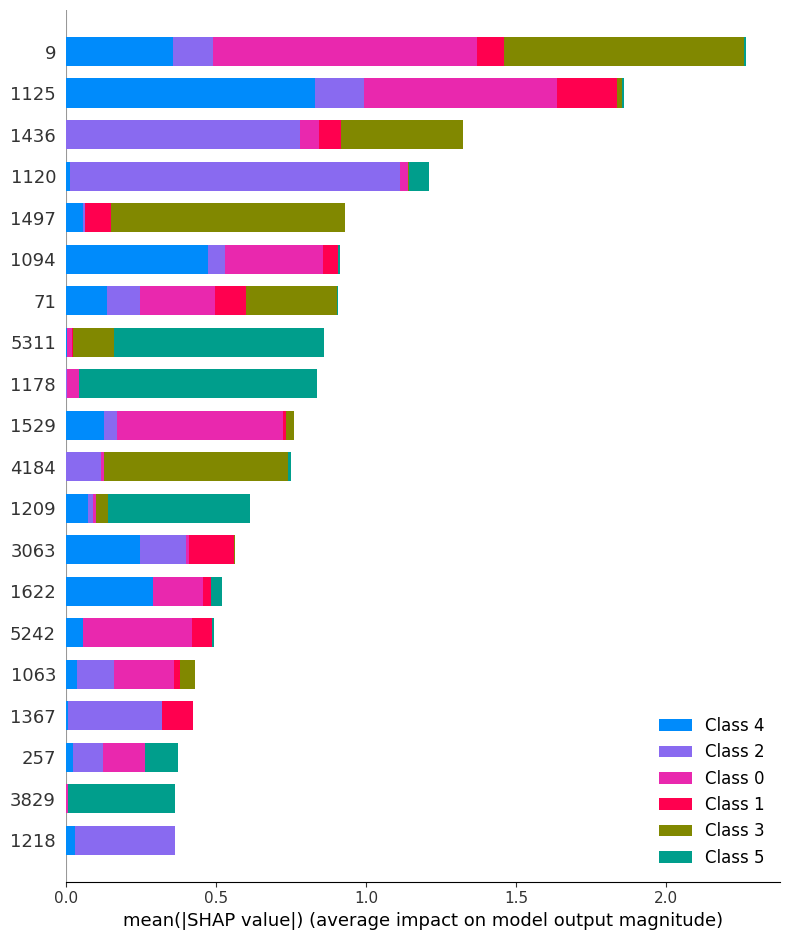

In [33]:
import shap

# Explain the model's predictions using SHAP by computing SHAP values
explainer = shap.Explainer(model_smile_comb)
shap_values = explainer.shap_values(train_feat_smile_comb_df)

#Convert the shap values for each class to a single list
shap_as_list=[]
for i in range(6):
    shap_as_list.append(shap_values[:,:,i])

# Plot the SHAP values
shap.summary_plot(shap_as_list, train_feat_smile_comb_df, plot_type="bar")